In [13]:
import os
import cv2
import numpy as np
from util_parse_3d_dataset import *
from cv2 import log
import torch
import imageio
import torch
from torch import nn

import rerun as rr
# from rerun.datatypes import Angle, Quaternion, Rotation3D, RotationAxisAngle
import rerun.blueprint as rrb

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def read_p2_matrix(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize an empty list for the P2 values
    p2_values = []

    # Loop through each line to find the line starting with "P2:"
    for line in lines:
        if line.startswith('P2:'):
            # Split the line after 'P2:' and convert the values to floats
            p2_values = [float(value) for value in line.split()[1:]]
            break

    # Convert the list of values into a 3x4 matrix
    p2_matrix = np.array(p2_values).reshape(3, 4)
    
    return p2_matrix

In [15]:
# Evaluation Metrics

class RunningAverage:
    def __init__(self):
        self.avg = 0
        self.count = 0

    def append(self, value):
        # assert type(value) in [int, float,np.float32], 'Value must be a number but got {}'.format(type(value))
        self.avg = (value + self.count * self.avg) / (self.count + 1)
        self.count += 1

    def get_value(self):
        return self.avg
    
class RunningAverageDict:
    """A dictionary of running averages."""
    def __init__(self):
        self._dict = None

    def update(self, new_dict):
        if new_dict is None:
            return

        if self._dict is None:
            self._dict = dict()
            for key, value in new_dict.items():
                self._dict[key] = RunningAverage()

        for key, value in new_dict.items():
            self._dict[key].append(value)

    def get_value(self):
        if self._dict is None:
            return None
        return {key: value.get_value() for key, value in self._dict.items()}
    
    def compute_errors(self,gt, pred):
        """Compute metrics for 'pred' compared to 'gt'

        Args:
            gt (numpy.ndarray): Ground truth values
            pred (numpy.ndarray): Predicted values

            gt.shape should be equal to pred.shape

        Returns:
            dict: Dictionary containing the following metrics:
                'a1': Delta1 accuracy: Fraction of pixels that are within a scale factor of 1.25
                'a2': Delta2 accuracy: Fraction of pixels that are within a scale factor of 1.25^2
                'a3': Delta3 accuracy: Fraction of pixels that are within a scale factor of 1.25^3
                'abs_rel': Absolute relative error
                'rmse': Root mean squared error
                'log_10': Absolute log10 error
                'sq_rel': Squared relative error
                'rmse_log': Root mean squared error on the log scale
                'silog': Scale invariant log error
        """
        thresh = np.maximum((gt / pred), (pred / gt))
        a1 = (thresh < 1.25).mean()
        a2 = (thresh < 1.25 ** 2).mean()
        a3 = (thresh < 1.25 ** 3).mean()

        error = np.abs(gt - pred)
        abs_rel = np.mean(error / gt)
        std_abs_rel = np.std(error / gt)
        # abs_rel = np.abs(gt - pred) / gt
        # map(lambda abs_rel_val: self.update(dict(abs_rel=abs_rel_val)), abs_rel)


        # for abs_rel_val in abs_rel:
        #     self.update(dict(abs_rel=abs_rel_val))

        sq_rel = np.mean(((gt - pred) ** 2) / gt)

        rmse = (gt - pred) ** 2
        rmse = np.sqrt(rmse.mean())

        rmse_log = (np.log(gt) - np.log(pred)) ** 2
        rmse_log = np.sqrt(rmse_log.mean())

        err = np.log(pred) - np.log(gt)
        silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

        log_10 = (np.abs(np.log10(gt) - np.log10(pred))).mean()


        self.update(dict(a1=a1, a2=a2, a3=a3, abs_rel=abs_rel,std_abs_rel=std_abs_rel, rmse=rmse, log_10=log_10, rmse_log=rmse_log,
                    silog=silog, sq_rel=sq_rel))
        
        return error,gt
        
    def compute_metrics(self,gt, pred, mask,interpolate=True, garg_crop=False, eigen_crop=True, dataset='nyu', **kwargs):#
        """Compute metrics of predicted depth maps. Applies cropping and masking as necessary or specified via arguments. Refer to compute_errors for more details on metrics.
        """

        #assert gt.size() == pred.size(), 'Shapes do not match'

        # print(f'Gt Shape: {gt.shape[-2:]} Pred Shape: {pred.shape[-2:]}')

        if gt.shape[-2:] != pred.shape[-2:] and interpolate:
            pred = pred.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            pred = nn.functional.interpolate(
                pred, gt.shape[-2:], mode='bilinear', align_corners=True)

        pred = pred.squeeze().cpu().numpy()
        # pred[pred < min_depth_eval] = min_depth_eval
        # pred[pred > max_depth_eval] = max_depth_eval
        # pred[np.isinf(pred)] = max_depth_eval
        # pred[np.isnan(pred)] = min_depth_eval

        gt_depth = gt.squeeze().cpu().numpy()
        # valid_mask = np.logical_and(
        #     gt_depth > min_depth_eval, gt_depth < max_depth_eval)
        if np.array_equal(mask,np.zeros(mask.shape)):
            return None,None
        else:
            return self.compute_errors(gt_depth[mask], pred[mask])

    

In [16]:
def read_my_test_set(path):
    data = []
    with open(path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            raw_path = parts[0]
            depth_path = parts[1]
            focal = parts[2]
            label_id = parts[3]
            date = raw_path.split('/')[0]
            drive = raw_path.split('/')[1]
            id = raw_path.split('/')[-1]
            data.append((date,drive,id,depth_path,focal,label_id))
    return data

In [17]:
def get_2d_bounding_box(points_3d):
    # Extract x and y coordinates from the points
    x_coords = points_3d[0, :]
    y_coords = points_3d[1, :]

    # Calculate xmin, ymin, xmax, ymax
    xmin = int(np.min(x_coords))
    ymin = int(np.min(y_coords))
    xmax = int(np.max(x_coords))
    ymax = int(np.max(y_coords))
    return xmin, ymin, xmax, ymax

In [18]:
%matplotlib inline

from gc import get_objects
from rerun import BlueprintLike


viz = False

crops = False

if viz:
    # rr.serve(open_browser=True, web_port=8080, ws_port=8081)
    rr.init("Depth Eval Viz",spawn=True)
# rr.notebook_show(width=1750, height=800)


my_test_set = read_my_test_set('C:\\Users\\Hasan\\OneDrive\\Desktop\\Projects\\TestKitti\\my_test_set.txt')
# abs_rel_framewise = []
# abs_rel_objects_framewise = []

pixel_eval_metrics = RunningAverageDict()
object_eval_metrics = RunningAverageDict()
object_mean_eval_metrics = RunningAverageDict()

midas_depth_error = []
gt_depth_midas = []

objects_absrel = []

for i,(date,drive,id,depth_path,focal,label_id) in enumerate(my_test_set):
    
    # Training Data
    img_path = os.path.join('C:/Users/Hasan/OneDrive/Documents/Datasets/KITTI/raw', date,drive,'image_02','data')
    labels_path = os.path.join('C:/Users/Hasan/Downloads/data/kitti/training/label_2')
    gt_depth_path = 'C:/Users/Hasan/OneDrive/Documents/Datasets/KITTI/data_depth_annotated/mixed'
    midas_pred_path = 'C:\\Users\\Hasan\\OneDrive\\Desktop\\Projects\\TestKitti\\MIDAS2_MySet'
    zoe_pred_path = 'C:\\Users\\Hasan\\OneDrive\\Desktop\\Projects\\TestKitti\\Zoe_MySet'
    depthanything_pred_path = 'C:\\Users\\Hasan\\OneDrive\\Desktop\\Projects\\TestKitti\\DepthAnything_MySet'
    depthanything_rel_path = 'C:\\Users\\Hasan\\OneDrive\\Desktop\\Projects\\TestKitti\\DepthAnythingRel_MySet'

    files = os.listdir(labels_path)
    files_path = [os.path.join(labels_path, f) for f in files if f.endswith('.txt')]


    img= cv2.imread(os.path.join(img_path, f'{id}'))
    gt_depth = np.array(imageio.imread(os.path.join('C:\\Users\\Hasan\\OneDrive\\Documents\\Datasets\\KITTI\\data_depth_annotated\\mixed',depth_path)), dtype=int).astype(float) / 256.0
    # midas_pred = np.load(os.path.join(midas_pred_path, f'{drive}_{id[:-4]}_depth.npy'))
    # midas_pred = np.load(os.path.join(depthanything_rel_path, f'{drive}_{id[:-4]}_depth_metric.npy'))[0]
    # midas_pred = np.load(os.path.join(zoe_pred_path, f'{drive}_{id[:-4]}.npy'))
    midas_pred = np.load(os.path.join(depthanything_pred_path, f'{drive}_{id[:-4]}.npy'))
    midas_pred = torch.Tensor(midas_pred).unsqueeze(0).unsqueeze(0) # Add batch and channel dimensions
    midas_pred = nn.functional.interpolate(
        midas_pred, gt_depth.shape[-2:], mode='bilinear', align_corners=True)
    midas_pred = midas_pred.squeeze().cpu().numpy()

    # print(f'MiDaS Pred SHape: {midas_pred.shape}')

    if crops:
        height = img.shape[0]
        width = img.shape[1]
        top_margin = int(height - 352)
        left_margin = int((width - 1216) / 2)
        img = img[top_margin:top_margin + 352,
                        left_margin:left_margin + 1216, :]
        gt_depth = gt_depth[top_margin:top_margin +
                            352, left_margin:left_margin + 1216]


    print(f'Frame iD: {i}')


    P2 = np.array(parse_calibration_file(os.path.join('C:/Users/Hasan/OneDrive/Documents/Datasets/KITTI/raw',date,'calib_cam_to_cam.txt'),raw=True)['P_rect_02']).reshape(3,4)
    K= P2[:3,:3]
    # print(f'P2: \n{P2}')
    # P2 =read_p2_matrix(os.path.join('C:/Users/Hasan/OneDrive/Documents/Datasets/KITTI/3D/training/calib',str(label_id).zfill(6)+'.txt'))
    # K = P2[:3,:3]

    # assert not np.array_equal(P2,P2_raw), f'P2 matrices do not match - P2: \n{P2} - P2_raw: \n{P2_raw}'
    # assert not np.array_equal(K,K_raw), f'K matrices do not match - K: \n{K} - K_raw: \n{K_raw}'

    label = parse_label_file2(files_path,int(float(label_id)))
    
    pose_is_center = False
    gt_centers = [
    proj_point 
    for gt_obj in label 
    if (proj_point := plot_proj_point(K, gt_obj, center=pose_is_center)) 
    and 0 < proj_point[0] < gt_depth.shape[1] 
    and 0 < proj_point[1] < gt_depth.shape[0]
    ]

    # for center in gt_centers:
    #     cv2.circle(img, (int(center[0]),int(center[1])), 5, (255,0,0), -1)


        
    min_depth_eval=0.1
    max_depth_eval=80

    gt_height, gt_width = gt_depth.shape

    pixels_mask = np.logical_and(gt_depth > min_depth_eval, gt_depth < max_depth_eval)

    if crops:
        garg_crop_mask = np.zeros(pixels_mask.shape)
        garg_crop_mask[int(0.40810811 * gt_height):int(0.99189189 * gt_height),
                        int(0.03594771 * gt_width):int(0.96405229 * gt_width)] = 1
        
        pixels_mask = np.logical_and(pixels_mask, garg_crop_mask)
    objects_mask = np.zeros(gt_depth.shape).astype(bool)

    assert not np.array_equal(pixels_mask,np.zeros(pixels_mask.shape)), f'Pixel Mask is wrong'
    for (x,y) in gt_centers:
        objects_mask[y,x] = True

    for (x,y) in gt_centers:

        if pixels_mask[y,x] == True:
            gt_depth_midas.append(gt_depth[y,x])
            midas_depth_error.append(np.abs(gt_depth[y,x] - midas_pred[y,x]))

    objects_mask = np.logical_and(objects_mask,pixels_mask)
    all_obj_mask = np.zeros(gt_depth.shape).astype(bool)
    
    error,gt = pixel_eval_metrics.compute_metrics(torch.Tensor(gt_depth), torch.Tensor(midas_pred),mask=pixels_mask)
    

    object_eval_metrics.compute_metrics(torch.Tensor(gt_depth), torch.Tensor(midas_pred),mask=objects_mask,centers=gt_centers)
    # object_eval_metrics.update(frame_object_metrics)
    object_mean_error_list = []
    object_mean_gt_list = []

    object_error_list = []
    object_gt_list = []
    for gt_obj in label:
        obj_mask = np.zeros(gt_depth.shape).astype(bool)
        gt_obj['bbox3d']= get_coords_3d(gt_obj,P2)[0]
        gt_obj['bbox2d'] = get_2d_bounding_box(gt_obj['bbox3d'])
        # img = plot_bbox_2d2(img,gt_obj)

        gt_center = plot_proj_point(K, gt_obj, center=pose_is_center)
        if 0 < gt_center[0] < gt_depth.shape[1] and 0 < gt_center[1] < gt_depth.shape[0]:
            if pixels_mask[gt_center[1],gt_center[0]] == True:
                object_gt = gt_depth[gt_center[1],gt_center[0]]
                object_pred = midas_pred[gt_center[1],gt_center[0]]
                object_error_list.append(np.abs(object_gt - object_pred))
                object_gt_list.append(object_gt)

        xmin, ymin, xmax, ymax = gt_obj['bbox2d']

        if 0 < xmin < gt_depth.shape[1] and 0 < xmax < gt_depth.shape[1] and 0 < ymin < gt_depth.shape[0] and 0 < ymax < gt_depth.shape[0]:
            obj_mask[ymin:ymax,xmin:xmax] = True
            obj_mask = np.logical_and(obj_mask,pixels_mask)
            all_obj_mask = np.logical_or(all_obj_mask,obj_mask)
            object_mean_error,object_mean_gt = object_eval_metrics.compute_metrics(torch.Tensor(gt_depth), torch.Tensor(midas_pred),mask=obj_mask)
            if object_mean_error is not None and object_mean_gt is not None:
                object_mean_error_list.append(np.mean(object_mean_error))
                object_mean_gt_list.append(np.mean(object_mean_gt))
            # object_mean_eval_metrics.update(object_absrel)
            # if object_absrel is not None:
            #     objects_absrel.append(object_absrel['abs_rel'])
        
    object_mean_eval_metrics.compute_metrics(torch.Tensor(gt_depth), torch.Tensor(midas_pred),mask=all_obj_mask)



    # Rerun Vizualizations
    if viz and len(object_gt_list) > 0:
        fig = plt.figure()
        plt.scatter(gt, error,label='Pixel Abs Error')
        plt.scatter(object_mean_gt_list,object_mean_error_list,label='Object Mean Abs Error')
        plt.scatter(object_gt_list,object_error_list,label='Object Abs Error')
        plt.xlabel('Ground Truth Depth [m]')
        plt.ylabel('Abs Error [m]')
        plt.title('Pixel AbsError Distribution as a function of ground truth depth\n Mean Abs Error: {:.4f}'.format(np.mean(error/gt)))
        plt.legend()
        fig.savefig(f'PixelScatter.png')
        #pixel_eval_metrics.update(frame_pixel_metrics)
        fig = plt.figure()
        midas_abs_rel = error/gt
        hist_obj = sns.histplot(midas_abs_rel, bins=300, edgecolor='k', alpha=0.7, binrange=(np.min(midas_abs_rel), np.max(midas_abs_rel)))

        low_bin_ranges = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        high_bin_ranges =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

        data = {}
        for low_range,high_range in zip(low_bin_ranges,high_bin_ranges):
            data[f'{low_range}-{high_range}'] = []
            for patch in hist_obj.patches:
                if patch.get_x() > low_range and patch.get_x()+patch.get_width() < high_range:
                    data[f'{low_range}-{high_range}'].append(patch.get_height())

            

        check_objects = 0
        count_range = 1
        for key,value in data.items():
            if count_range == 5:
                break
            # print(f'{key} : {sum(value)}')
            check_objects += sum(value)
            plt.scatter([-100], [-100], c='white', label=f'{(100*sum(value)/len(midas_abs_rel)):.2f} % of Objects lie in Abs Rel Range {key}')
            count_range += 1


        plt.xlabel('AbsRel')
        plt.ylabel('Pixel Count')
        plt.title('Histogram showing AbsRel distribution of objects \n Mean AbsRel: {:.2f}'.format(np.mean(midas_abs_rel)))
        plt.legend()
        plt.xlim(0,2)
        # if len(data['0.0-0.1']) >= 1:
        #     ylimit = data['0.0-0.1'][0]
        # else:
        #     ylimit = data['0.0-0.1']

        if len(data['0.0-0.1']) != 0:
            plt.ylim(0,max(data['0.0-0.1'])*1.1)
        else:
            raise ValueError('No objects in range 0.0-0.1')
        
        fig.savefig(f'PixelHist.png')
        rr.set_time_sequence("Frame ID: ", i)
        rr.set_time_seconds('Frame ID: ', i)

        
        
        rr.log("/world/gt_depth", rr.Image(gt_depth))
        rr.log("/world/pred_depth", rr.Image(midas_pred))
        rr.log("/world/image", rr.Image(img[:,:,::-1]))
        rr.log('/world/pixel_mask', rr.Image(pixels_mask.astype(np.uint8)*255))
        # rr.log('/world/object_mask', rr.Image(objects_mask.astype(np.uint8)*255))
        rr.log('/world/all_obj_mask', rr.Image(all_obj_mask.astype(np.uint8)*255))



        rr.log("/world/all_obj_mask/box2D", rr.Boxes2D(
            mins=[[xmin, ymin] for xmin, ymin, xmax, ymax in [gt_obj['bbox2d'] for gt_obj in label] 
              if 0 <= xmin < gt_depth.shape[1] and 0 <= xmax < gt_depth.shape[1] and 0 <= ymin < gt_depth.shape[0] and 0 <= ymax < gt_depth.shape[0]],
            sizes=[[np.abs(xmax - xmin), np.abs(ymax - ymin)] for xmin, ymin, xmax, ymax in [gt_obj['bbox2d'] for gt_obj in label] 
               if 0 <= xmin < gt_depth.shape[1] and 0 <= xmax < gt_depth.shape[1] and 0 <= ymin < gt_depth.shape[0] and 0 <= ymax < gt_depth.shape[0]]
        ))

        rr.log("/world/image/box2D", rr.Boxes2D(
            mins=[[xmin, ymin] for xmin, ymin, xmax, ymax in [gt_obj['bbox2d'] for gt_obj in label] 
              if 0 <= xmin < gt_depth.shape[1] and 0 <= xmax < gt_depth.shape[1] and 0 <= ymin < gt_depth.shape[0] and 0 <= ymax < gt_depth.shape[0]],
            sizes=[[np.abs(xmax - xmin), np.abs(ymax - ymin)] for xmin, ymin, xmax, ymax in [gt_obj['bbox2d'] for gt_obj in label] 
               if 0 <= xmin < gt_depth.shape[1] and 0 <= xmax < gt_depth.shape[1] and 0 <= ymin < gt_depth.shape[0] and 0 <= ymax < gt_depth.shape[0]]
        ))

        rr.log("/world/pixel_mask/box2D", rr.Boxes2D(
            mins=[[xmin, ymin] for xmin, ymin, xmax, ymax in [gt_obj['bbox2d'] for gt_obj in label] 
              if 0 <= xmin < gt_depth.shape[1] and 0 <= xmax < gt_depth.shape[1] and 0 <= ymin < gt_depth.shape[0] and 0 <= ymax < gt_depth.shape[0]],
            sizes=[[np.abs(xmax - xmin), np.abs(ymax - ymin)] for xmin, ymin, xmax, ymax in [gt_obj['bbox2d'] for gt_obj in label] 
               if 0 <= xmin < gt_depth.shape[1] and 0 <= xmax < gt_depth.shape[1] and 0 <= ymin < gt_depth.shape[0] and 0 <= ymax < gt_depth.shape[0]]
        ))

        rr.log("/world/pred_depth/box2D", rr.Boxes2D(
            mins=[[xmin, ymin] for xmin, ymin, xmax, ymax in [gt_obj['bbox2d'] for gt_obj in label] 
              if 0 <= xmin < gt_depth.shape[1] and 0 <= xmax < gt_depth.shape[1] and 0 <= ymin < gt_depth.shape[0] and 0 <= ymax < gt_depth.shape[0]],
            sizes=[[np.abs(xmax - xmin), np.abs(ymax - ymin)] for xmin, ymin, xmax, ymax in [gt_obj['bbox2d'] for gt_obj in label] 
               if 0 <= xmin < gt_depth.shape[1] and 0 <= xmax < gt_depth.shape[1] and 0 <= ymin < gt_depth.shape[0] and 0 <= ymax < gt_depth.shape[0]]
        ))


        rr.log("/world/image/points", rr.Points2D([[gt_center[0],gt_center[1]] for gt_center in gt_centers], colors=[[255,0,0]*len(gt_centers)], radii=[[5]*len(gt_centers)]))
        rr.log("/world/pixel_mask/points", rr.Points2D([[gt_center[0],gt_center[1]] for gt_center in gt_centers], colors=[[255,0,0]*len(gt_centers)], radii=[[5]*len(gt_centers)]))
        rr.log("/world/object_mask/points", rr.Points2D([[gt_center[0],gt_center[1]] for gt_center in gt_centers], colors=[[255,0,0]*len(gt_centers)], radii=[[5]*len(gt_centers)]))
        rr.log("/world/pred_depth/points", rr.Points2D([[gt_center[0],gt_center[1]] for gt_center in gt_centers], colors=[[255,0,0]*len(gt_centers)], radii=[[5]*len(gt_centers)]))
        rr.log("/world/gt_depth/points", rr.Points2D([[gt_center[0],gt_center[1]] for gt_center in gt_centers], colors=[[255,0,0]*len(gt_centers)], radii=[[5]*len(gt_centers)]))
        
        # Statistics
        pixel_scatter = cv2.imread('PixelScatter.png')
        rr.log("/pixel_scatter", rr.Image(pixel_scatter[:,:,::-1]))
        pixel_hist = cv2.imread('PixelHist.png')
        rr.log("/pixel_hist", rr.Image(pixel_hist[:,:,::-1]))


print(f'Pixel Eval Metrics: \n{pixel_eval_metrics.get_value()}')
print(f'Object Eval Metrics: \n{object_eval_metrics.get_value()}')
print(f'Object Mean Eval Metrics: \n{object_mean_eval_metrics.get_value()}')
# print(f'Object Abs Rel: \n{np.mean(objects_absrel)}')
        
    



C:\Users\Hasan\AppData\Local\Temp\ipykernel_5384\3334233026.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_depth = np.array(imageio.imread(os.path.join('C:\\Users\\Hasan\\OneDrive\\Documents\\Datasets\\KITTI\\data_depth_annotated\\mixed',depth_path)), dtype=int).astype(float) / 256.0


Frame iD: 0
Frame iD: 1
Frame iD: 2
Frame iD: 3
Frame iD: 4
Frame iD: 5
Frame iD: 6
Frame iD: 7
Frame iD: 8
Frame iD: 9
Frame iD: 10
Frame iD: 11
Frame iD: 12


C:\Users\Hasan\AppData\Local\Temp\ipykernel_5384\2107204022.py:83: RuntimeWarning: invalid value encountered in sqrt
  silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100


Frame iD: 13
Frame iD: 14
Frame iD: 15
Frame iD: 16
Frame iD: 17
Frame iD: 18
Frame iD: 19
Frame iD: 20
Frame iD: 21
Frame iD: 22
Frame iD: 23
Frame iD: 24
Frame iD: 25
Frame iD: 26
Frame iD: 27
Frame iD: 28
Frame iD: 29
Frame iD: 30
Frame iD: 31
Frame iD: 32
Frame iD: 33
Frame iD: 34
Frame iD: 35
Frame iD: 36
Frame iD: 37
Frame iD: 38
Frame iD: 39
Frame iD: 40
Frame iD: 41
Frame iD: 42
Frame iD: 43
Frame iD: 44
Frame iD: 45
Frame iD: 46
Frame iD: 47
Frame iD: 48
Frame iD: 49
Frame iD: 50
Frame iD: 51
Frame iD: 52
Frame iD: 53
Frame iD: 54
Frame iD: 55
Frame iD: 56
Frame iD: 57
Frame iD: 58
Frame iD: 59
Frame iD: 60
Frame iD: 61
Frame iD: 62
Frame iD: 63
Frame iD: 64
Frame iD: 65
Frame iD: 66
Frame iD: 67
Frame iD: 68
Frame iD: 69
Frame iD: 70
Frame iD: 71
Frame iD: 72
Frame iD: 73
Frame iD: 74
Frame iD: 75
Frame iD: 76
Frame iD: 77
Frame iD: 78
Frame iD: 79
Frame iD: 80
Frame iD: 81
Frame iD: 82
Frame iD: 83
Frame iD: 84
Frame iD: 85
Frame iD: 86
Frame iD: 87
Frame iD: 88
Frame iD: 89

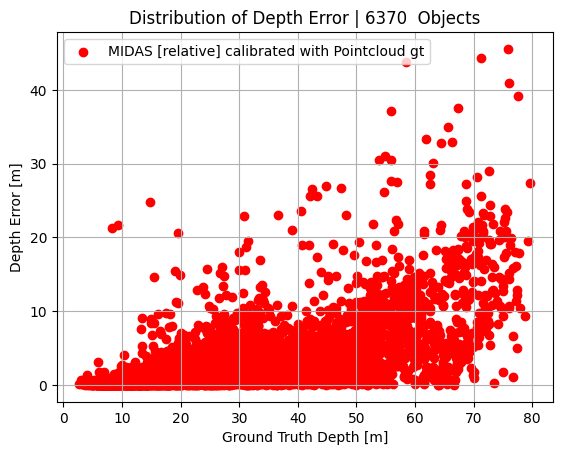

In [19]:
import matplotlib.pyplot as plt

plt.scatter(gt_depth_midas,midas_depth_error, c='r', label='MIDAS [relative] calibrated with Pointcloud gt')
# plt.scatter(gt_depth_zoe,zoe_depth_error, c='b', label='ZoeDepth [metric] finetuned')
# plt.scatter(gt_depth_depth_anything,depth_anything_depth_error, c='g', label='DepthAnything [relative] calibrated with Pointcloud gt')
# plt.scatter(gt_depth_depthanything_metric,depthanything_metric_depth_error, c='y', label='DepthAnything [metric] finetuned')
plt.xlabel('Ground Truth Depth [m]')
plt.ylabel('Depth Error [m]')
# plt.xlim([0,max(gt_depth_midas)+10])
# plt.ylim([0,max(midas_depth_error)+10])
plt.title(f'Distribution of Depth Error | {len(gt_depth_midas)}  Objects')
plt.legend()
plt.grid()
plt.show()

In [20]:
gt_depth_midas = np.array(gt_depth_midas)
midas_depth_error = np.array(midas_depth_error)

bin_size = 10
bins = np.arange(0, gt_depth_midas.max() + bin_size, bin_size)

# Initialize arrays to store the mean errors and the counts in each interval
mean_errors = []
interval_counts = []

# Loop through the bins and calculate mean error for each interval
for i in range(len(bins) - 1):
    start = bins[i]
    end = bins[i + 1]
    
    # Get the indices of the ground truth depth values that fall into the current interval
    indices = np.where((gt_depth_midas >= start) & (gt_depth_midas < end))[0]
    
    if len(indices) > 0:
        # Calculate the mean error for the current interval
        mean_error = np.mean(midas_depth_error[indices])
        mean_errors.append(mean_error)
        interval_counts.append(len(indices))
    else:
        # If no values fall into the interval, append NaN
        mean_errors.append(np.nan)
        interval_counts.append(0)

# Convert results to numpy arrays for consistency
mean_errors_midas = np.array(mean_errors)
interval_counts_midas = np.array(interval_counts)

print(f'Max Gt Depth: {gt_depth_midas.max()}')

Max Gt Depth: 79.69140625


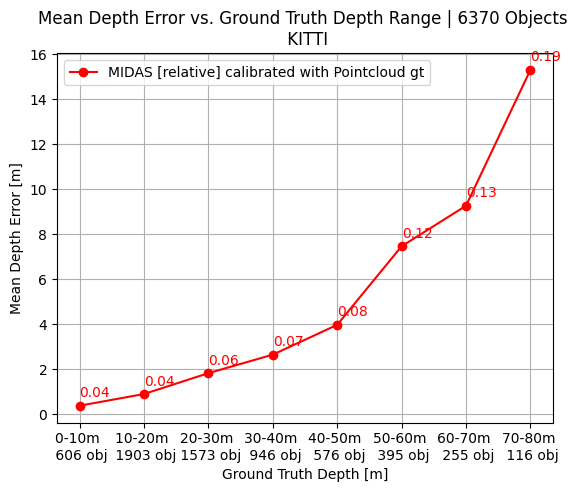

In [21]:
np.save('ZoeDepthBins.npy',bins)
np.save('ZoeDepthMeanErrors.npy',mean_errors_midas)
np.save('ZoeDepthIntervalCounts.npy',interval_counts_midas)
np.save('ZoeDepthErrors.npy',midas_depth_error)
plt.plot(bins[:-1], mean_errors_midas, 'r-', marker='o', label='MIDAS [relative] calibrated with Pointcloud gt')
# plt.plot(bins[:-1], mean_errors_zoe, 'b-', marker='o', label='ZoeDepth [metric] finetuned on kitti')
# plt.plot(bins[:-1], mean_errors_depth_anything, 'g-', marker='o', label='DepthAnything [relative] calibrated with Pointcloud gt')
# plt.plot(bins[:-1], mean_errors_depthanything_metric, 'y-', marker='o', label='DepthAnything [metric] finetuned on kitti')

# Adding the y-values as text labels
bin_range = 10
for i in range(len(bins)-1):
    plt.text(bins[i], mean_errors_midas[i]+0.25, f'{mean_errors_midas[i]/bin_range:.2f}', color='red', ha='left', va='bottom')
    bin_range += 10
    # plt.text(bins[i], mean_errors_depth_anything[i], f'{mean_errors_depth_anything[i]:.2f}', color='green', ha='left', va='bottom')

plt.xlabel('Ground Truth Depth [m]')
plt.ylabel('Mean Depth Error [m]')
plt.title(f'Mean Depth Error vs. Ground Truth Depth Range | {len(midas_depth_error)} Objects \n KITTI')

xtick_labels = [f'{int(bins[i])}-{int(bins[i + 1])}m \n {interval_counts_midas[i]} obj' for i in range(len(bins)-1)]
# xtick_labels = [f'{int(bins[i])}-{int(bins[i + 1])}m \n {interval_counts_midas[i]} obj \n {interval_counts_zoe[i]} obj \n {interval_counts_depth_anything[i]} obj' for i in range(len(bins)-1)]
plt.xticks(bins[:-1], xtick_labels)

plt.legend()
plt.grid()

0.0-0.1 : 4258
0.1-0.2 : 906
0.2-0.3 : 273
0.3-0.4 : 65
5502 = 6370


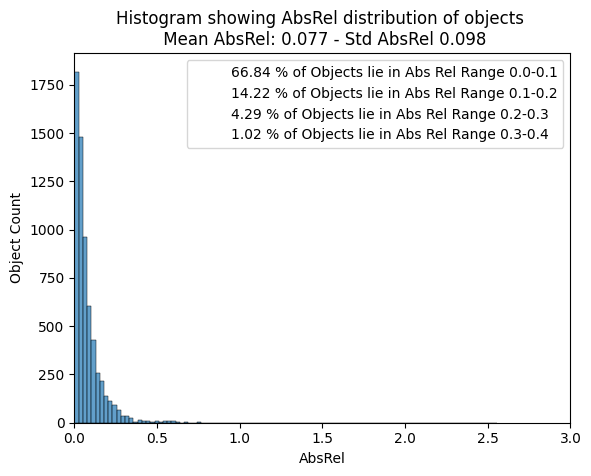

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

midas_abs_rel = np.abs(midas_depth_error) / gt_depth_midas

hist_obj = sns.histplot(midas_abs_rel, bins=100, edgecolor='k', alpha=0.7, binrange=(np.min(midas_abs_rel), np.max(midas_abs_rel)))

low_bin_ranges = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
high_bin_ranges =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

data = {}
for low_range,high_range in zip(low_bin_ranges,high_bin_ranges):
    data[f'{low_range}-{high_range}'] = []
    for patch in hist_obj.patches:
        if patch.get_x() > low_range and patch.get_x()+patch.get_width() < high_range:
            data[f'{low_range}-{high_range}'].append(patch.get_height())

    

check_objects = 0
count_range = 1
for key,value in data.items():
    if count_range == 5:
        break
    print(f'{key} : {sum(value)}')
    check_objects += sum(value)
    plt.scatter([-100], [-100], c='white', label=f'{(100*sum(value)/len(midas_abs_rel)):.2f} % of Objects lie in Abs Rel Range {key}')
    count_range += 1


print(f'{check_objects} = {len(midas_abs_rel)}')

plt.xlim([0,3])
# Get the current y-limits
current_ylim = plt.ylim()

# Set the lower bound and keep the current upper bound
plt.ylim([0, current_ylim[1]])
plt.xlabel('AbsRel')
plt.ylabel('Object Count')
plt.title('Histogram showing AbsRel distribution of objects \n Mean AbsRel: {:.3f} - Std AbsRel {:.3f}'.format(np.mean(midas_abs_rel),np.std(midas_abs_rel)))
plt.legend()